# **Installing the needed Libraries**

In [1]:
!pip install evaluate
!pip install -U bitsandbytes
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=29c4e00b242e5012d8d0c74052e77866ab7df7a0046d21c2a550c950358b7195
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# **Imports**

In [2]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import word_tokenize

import torch
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate
import torch
import bitsandbytes as bnb
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import nltk

from torch.utils.data import DataLoader
import torch

import torch
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import evaluate

In [3]:
# Download the necessary tokenizer resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Setting a fixed seed so the results are the same every time the code runs
SEED = 42
torch.manual_seed(SEED)

In [5]:
# Checking if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Seting a plotting style for the plots
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)

# **Loading the data**

In [ ]:
dataset = load_dataset("csv", data_files={
    "train": "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv",
    "validation": "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv",
    "test": "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv"
})

In [8]:
# Displaying the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 11490
    })
})


In [9]:
# Printing some samples of the data
print(dataset["train"][0])  # Printing the first training sample
print("=====================================================================")
print(dataset["train"][1])  # Printing the second training sample

{'id': '0001d1afc246a7964130f43ae940af6bc6c57f01', 'article': "By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through cont

In [10]:
# Printing some samples
print(dataset["test"][0])  # Printing the first test sample
print("=====================================================================")
print(dataset["validation"][0])  # Printing the first validation sample

{'id': '92c514c913c0bdfe25341af9fd72b29db544099b', 'article': "Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowd

# Checking the  null values

In [11]:
# Loading the train dataset using pandas to check the nulls
train_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
train_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

In [12]:
# Loading the validation dataset using pandas to check the nulls
valid_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv")
valid_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

# Checking the duplicates

In [13]:
train_df.duplicated().sum()

0

# Observation:
### There is no nulls or duplicates in the dataset,so the data is clean and ready for analysis.
-----------------------------------------

# **Visualizations**
### Plotting the distribution of the length of the text in the articles and their summaries by using a histogram

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


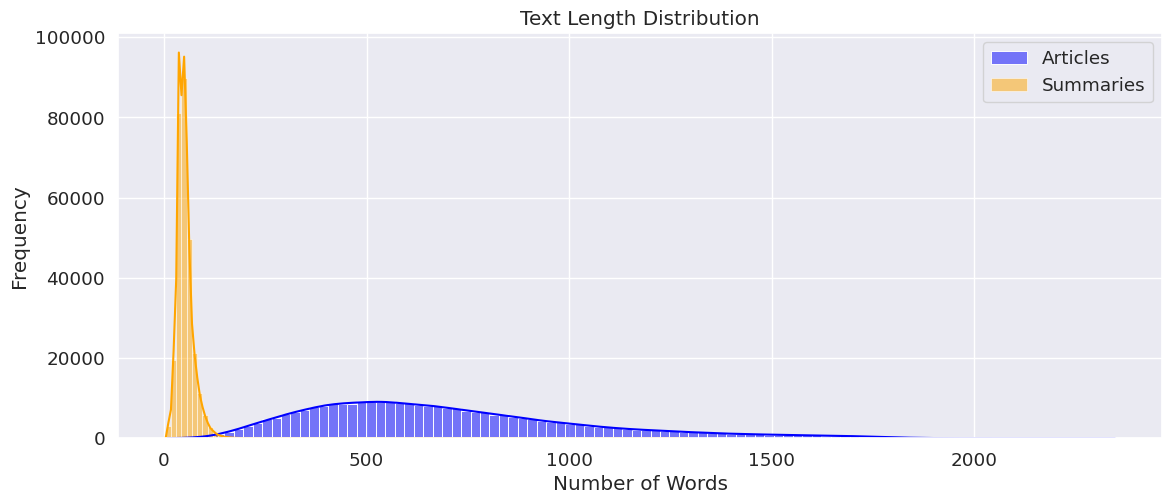

In [14]:
# Checking the article and the summaries length distribution
article_lengths = [len(article.split()) for article in dataset["train"]["article"]]
summary_lengths = [len(summary.split()) for summary in dataset["train"]["highlights"]]

plt.figure(figsize=(12, 5))
sns.histplot(article_lengths, bins=100, kde=True, label="Articles", color="blue")
sns.histplot(summary_lengths, bins=100, kde=True, label="Summaries", color="orange")
plt.legend()
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


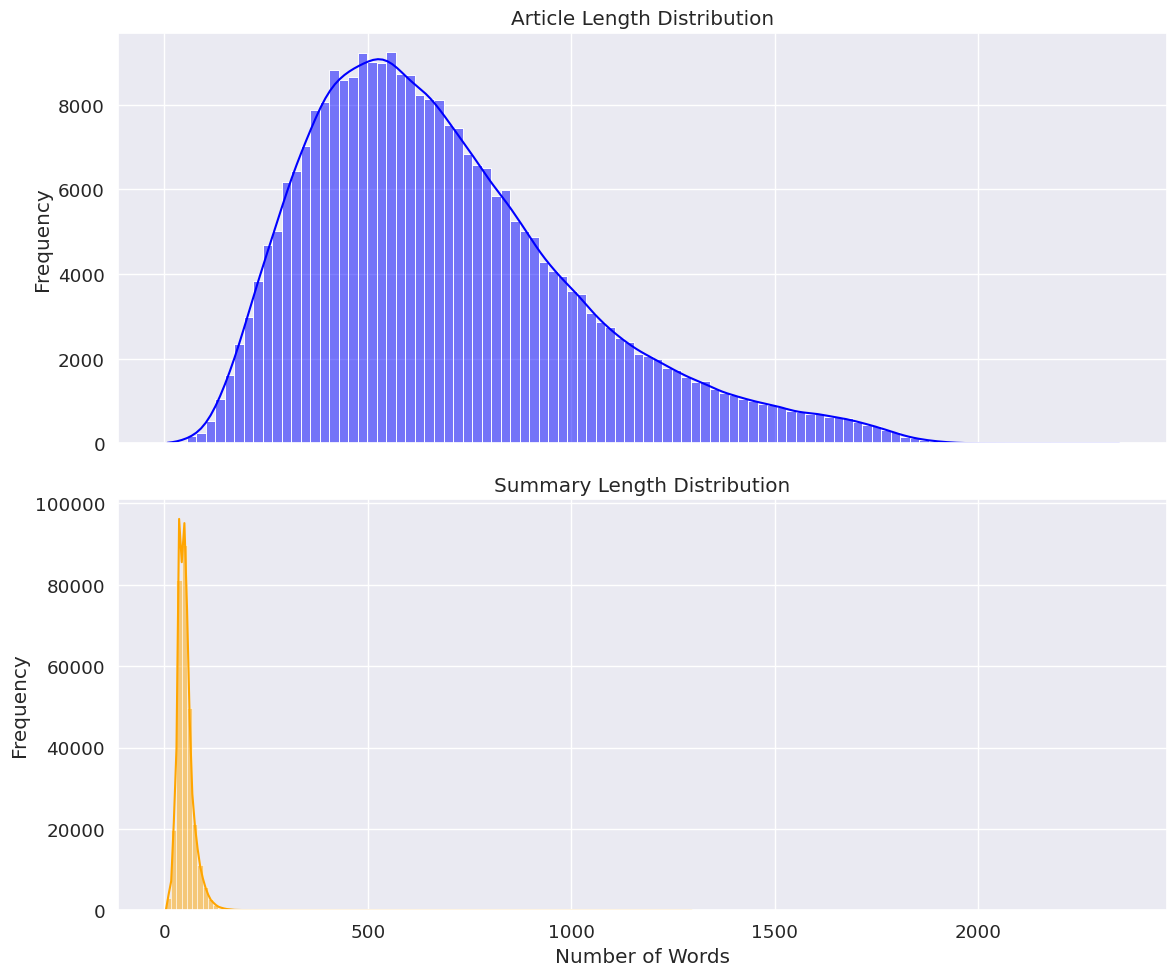

In [15]:
# Defining the figure and the subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plotring the article length distribution
sns.histplot(article_lengths, bins=100, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Article Length Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Frequency")

# Plotting the summary length distribution
sns.histplot(summary_lengths, bins=100, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Summary Length Distribution")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

 ## Printing the article and summary lengths

In [16]:
# Function to print the distribution of the article and summaries
def print_distribution_stats(lengths, text_type):
    print(f"{text_type} Length Distribution:")
    print(f"- Minimum: {np.min(lengths)} words")
    print(f"- Maximum: {np.max(lengths)} words")
    print(f"- Mean: {np.mean(lengths):.2f} words")
    print(f"- Median: {np.median(lengths)} words")
    print(f"- 25th percentile: {np.percentile(lengths, 25)} words")
    print(f"- 75th percentile: {np.percentile(lengths, 75)} words")
    print(f"- 90th percentile: {np.percentile(lengths, 90)} words")
    print("-" * 50)

In [17]:
# Calculating the article and summary lengths in the Training set
article_lengths = [len(article.split()) for article in dataset["train"]["article"]]
summary_lengths = [len(summary.split()) for summary in dataset["train"]["highlights"]]
# Print stats for articles and summaries
print ("Training Distribution\n")
print_distribution_stats(article_lengths, "Article")
print_distribution_stats(summary_lengths, "Summary")

Training Distribution

Article Length Distribution:
- Minimum: 8 words
- Maximum: 2347 words
- Mean: 691.87 words
- Median: 632.0 words
- 25th percentile: 443.0 words
- 75th percentile: 877.0 words
- 90th percentile: 1166.0 words
--------------------------------------------------
Summary Length Distribution:
- Minimum: 4 words
- Maximum: 1296 words
- Mean: 51.57 words
- Median: 48.0 words
- 25th percentile: 38.0 words
- 75th percentile: 60.0 words
- 90th percentile: 77.0 words
--------------------------------------------------


## Analysis:
#### Since most of the articles are falling within the range of 632–1166 words,we can set the Max Article Length to be 1200 tokens/words to match the dataset's 90th percentile (1166 words)
---------------------------------
#### Also for the summaries, since 90% of summaries are <= 77 words, we can set the Max Summary Length to be 80 tokens	

In [18]:
# Calculating the article and summary lengths in the Validation set
article_lengths = [len(article.split()) for article in dataset["validation"]["article"]]
summary_lengths = [len(summary.split()) for summary in dataset["validation"]["highlights"]]
# Print stats for articles and summaries
print ("Validation Distribution\n")
print_distribution_stats(article_lengths, "Article")
print_distribution_stats(summary_lengths, "Summary")

Validation Distribution

Article Length Distribution:
- Minimum: 41 words
- Maximum: 1917 words
- Mean: 676.03 words
- Median: 608.0 words
- 25th percentile: 413.75 words
- 75th percentile: 868.0 words
- 90th percentile: 1168.0 words
--------------------------------------------------
Summary Length Distribution:
- Minimum: 10 words
- Maximum: 1440 words
- Mean: 57.91 words
- Median: 54.0 words
- 25th percentile: 41.0 words
- 75th percentile: 69.0 words
- 90th percentile: 87.0 words
--------------------------------------------------


# Creating a function for the tokenization

In [19]:
def prepare_data(tokenizer, max_input_length=1200, max_target_length=80):
    """Tokenizes the dataset for T5 model."""

    # Tokenization function
    def tokenize_fn(example):
        inputs = tokenizer(
            example["article"], # The articles
            max_length=max_input_length, 
            padding="max_length", 
            truncation=True
        )
        targets = tokenizer(
            example["highlights"],  # The summaries
            max_length=max_target_length, 
            padding="max_length", 
            truncation=True
        )

        inputs["labels"] = targets["input_ids"]
        return inputs

    # Tokenize datasets
    tokenized_datasets = dataset.map(
        tokenize_fn, 
        batched=True, 
        num_proc=1, 
        remove_columns=["article", "highlights"]
    )

    # Convert format for PyTorch
    tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return tokenized_datasets["train"], tokenized_datasets["validation"], tokenized_datasets["test"]

# Creating our model

In [20]:
# Loading the model and the tokenizer
model_name = "t5-small" 
tokenizer = T5Tokenizer.from_pretrained(model_name)
train_dataset, val_dataset, test_dataset = prepare_data(tokenizer) # Preparing the training, validation, and the test datasets

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [21]:
# Loading the model with the QLoRA fine-tuning
model = T5ForConditionalGeneration.from_pretrained(
    model_name,
    load_in_4bit=True, # Loading the model in 4-bit precision for memory efficiency
    device_map="auto",
    torch_dtype=torch.float16 
)
# Preparing the model for the low-bit training (QLoRA)
model = prepare_model_for_kbit_training(model)

# The LoRA configuration
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
    target_modules=["q", "v"]
)
model = get_peft_model(model, lora_config) # Applying the LoRA to the model

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [22]:
# Defining the Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-qlora-checkpoints",
    evaluation_strategy="steps",
    learning_rate=2e-4,
    max_steps=1000,
    logging_steps=50,
    eval_steps=100,
    save_steps=200,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    fp16=True,
    optim="paged_adamw_8bit",
    report_to="none",
    predict_with_generate=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
# Defining the Data Collator
collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Defining the traier
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collator,
)
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch

Step,Training Loss,Validation Loss
100,2.734000,1.773516
200,1.941200,1.671020
300,1.732600,1.626275
400,1.736700,1.612259
500,1.698800,1.604090
600,1.693700,1.597604
700,1.725300,1.590135
800,1.635300,1.588409
900,1.678500,1.585238
1000,1.662600,1.583956


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you ne

TrainOutput(global_step=1000, training_loss=1.9694009246826172, metrics={'train_runtime': 5633.6003, 'train_samples_per_second': 2.84, 'train_steps_per_second': 0.178, 'total_flos': 5347108454400000.0, 'train_loss': 1.9694009246826172, 'epoch': 0.05572660527452319})

# **Evaluating the model**

In [24]:
# Evaluating the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 1.5839563608169556, 'eval_runtime': 403.5765, 'eval_samples_per_second': 33.124, 'eval_steps_per_second': 8.281, 'epoch': 0.05572660527452319}


# **Saving the final model**

In [25]:
trainer.save_model("t5-qlora-finetuned")
tokenizer.save_pretrained("t5-qlora-finetuned")

('t5-qlora-finetuned/tokenizer_config.json',
 't5-qlora-finetuned/special_tokens_map.json',
 't5-qlora-finetuned/spiece.model',
 't5-qlora-finetuned/added_tokens.json')

# Testing the model on new unseen articles

In [26]:
# Testing the model on new unseen articles
def generate_summary(text):
    inputs = tokenizer("summarize: " + text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128, temperature=0.7, top_p=0.9, do_sample=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
test_text = "summarize: A massive data breach at one of the UK's largest telecommunications companies has exposed the personal information of over 10 million customers, including names, addresses, and payment details. The breach, which occurred last week, was confirmed by the company in a statement released early this morning. Cybersecurity experts are calling it one of the most significant breaches in recent years, with fears that the stolen data could be used for identity theft and financial fraud."
print("Generated Summary:", generate_summary(test_text))

Generated Summary: Data breach was confirmed by the company in a statement released early this morning. Cybersecurity experts are calling it one of the most significant breaches in recent years.


In [28]:
test_text = "summarize:Scientists have recently discovered a new species of deep-sea fish that emits bioluminescent light to communicate and attract prey. This species, found at depths of over 2,000 meters in the Pacific Ocean, has adapted to the extreme pressure and darkness by developing specialized organs that produce light. Researchers believe that understanding these adaptations could lead to advancements in biotechnology, particularly in medical imaging and bioengineering. The discovery highlights the vast, unexplored biodiversity of the deep sea and the importance of preserving oceanic ecosystems from human-induced threats such as pollution and climate change."
print("Generated Summary:", generate_summary(test_text))

Generated Summary: a new fish was found at depths of 2,000 meters in the Pacific Ocean. It has adapted to the extreme pressure and darkness by developing organs that produce light.


In [30]:
test_text = "summarize: A 45-year-old man has been rescued after being trapped for over 12 hours in a collapsed mine shaft in rural Wyoming. The man, identified as John Harper, was part of a small team conducting exploratory drilling when the shaft gave way, burying him under several feet of rubble. Emergency crews worked tirelessly through the night to free him, using specialized equipment to clear debris and stabilize the area."
print("Generated Summary:", generate_summary(test_text))

Generated Summary: John Harper was part of a small team conducting exploratory drilling when the shaft gave way.


# The model evaluation (ROUGE and BLUE scores)

In [31]:
from evaluate import load
from tabulate import tabulate  # For better table formatting to print the rouge and blue models in a table form
# Loading the evaluation metrics
rouge = load("rouge")
bleu = load("bleu")

# Evaluating the model on only 100 samples of the test dataset to optimize the memory usage.

In [32]:
def evaluate_model(model, tokenizer, test_dataset, num_samples=100):
    model.eval()
    predictions, references = [], []
    
    for i in range(min(num_samples, len(test_dataset))):
        input_text = "summarize: " + tokenizer.decode(test_dataset[i]["input_ids"], skip_special_tokens=True)
        reference_text = tokenizer.decode(test_dataset[i]["labels"], skip_special_tokens=True)
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=128, temperature=0.7, top_p=0.9, do_sample=True)
        
        predictions.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        references.append([reference_text]) 

    # The ROUGE scores
    rouge = load("rouge")
    rouge_scores = rouge.compute(predictions=predictions, references=[r[0] for r in references])

    # The BLEU scores
    bleu = load("bleu")
    bleu_scores = bleu.compute(predictions=predictions, references=references)  # Correctly formatted

    # Printing the results
    print("\nROUGE & BLEU Scores:\n", tabulate([
    ["ROUGE-1", rouge_scores["rouge1"]],
    ["ROUGE-2", rouge_scores["rouge2"]],
    ["ROUGE-L", rouge_scores["rougeL"]],
    ["BLEU", bleu_scores["bleu"]]
    ], headers=["Metric", "Score"], tablefmt="grid"))



# Running the evaluation
evaluate_model(model, tokenizer, test_dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 512). Running this sequence through the model will result in indexing errors



ROUGE & BLEU Scores:
 +----------+----------+
| Metric   |    Score |
+==========+==========+
| ROUGE-1  | 0.34913  |
+----------+----------+
| ROUGE-2  | 0.150141 |
+----------+----------+
| ROUGE-L  | 0.256049 |
+----------+----------+
| BLEU     | 0.10512  |
+----------+----------+


# Evaluating the model again on a bigger number of samples (on 2000 saples) of the test dataset. 

In [33]:
def evaluate_model(model, tokenizer, test_dataset, num_samples=2000):
    model.eval()
    predictions, references = [], []
    
    for i in range(min(num_samples, len(test_dataset))):
        input_text = "summarize: " + tokenizer.decode(test_dataset[i]["input_ids"], skip_special_tokens=True)
        reference_text = tokenizer.decode(test_dataset[i]["labels"], skip_special_tokens=True)
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=128, temperature=0.7, top_p=0.9, do_sample=True)
        
        predictions.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        references.append([reference_text])  # Ensure reference is wrapped in a list

    # Compute ROUGE scores
    rouge = load("rouge")
    rouge_scores = rouge.compute(predictions=predictions, references=[r[0] for r in references])

    # Compute BLEU scores
    bleu = load("bleu")
    bleu_scores = bleu.compute(predictions=predictions, references=references)  # Correctly formatted

    # Print results
    print("\nROUGE & BLEU Scores:\n", tabulate([
    ["ROUGE-1", rouge_scores["rouge1"]],
    ["ROUGE-2", rouge_scores["rouge2"]],
    ["ROUGE-L", rouge_scores["rougeL"]],
    ["BLEU", bleu_scores["bleu"]]
    ], headers=["Metric", "Score"], tablefmt="grid"))


# Run evaluation
evaluate_model(model, tokenizer, test_dataset)


ROUGE & BLEU Scores:
 +----------+----------+
| Metric   |    Score |
+==========+==========+
| ROUGE-1  | 0.358656 |
+----------+----------+
| ROUGE-2  | 0.157494 |
+----------+----------+
| ROUGE-L  | 0.26219  |
+----------+----------+
| BLEU     | 0.123555 |
+----------+----------+
